In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# import os

# for root, dirs, files in os.walk("/content/drive"):
#     for name in files:
#         if name == "dat_train1.csv":
#             print(os.path.join(root, name))
#             break
#         break

/content/drive/.shortcut-targets-by-id/1vkknCL6OjwZzWbtKB-zBXYSXEFQyKkjV/stats m148/dat_train1.csv


KeyboardInterrupt: 

## Task 1

In [1]:
import pandas as pd

# file_path = '/content/drive/.shortcut-targets-by-id/1vkknCL6OjwZzWbtKB-zBXYSXEFQyKkjV/stats m148/dat_train1.csv'
file_path = 'dat_train1.csv'

df = pd.read_csv(file_path, parse_dates=['event_timestamp'])



In [2]:
df.head()

,customer_id,account_id,ed_id,event_name,event_timestamp,journey_steps_until_end,id,sep
0,15849251,383997507,4,browse_products,2021-11-04 14:11:15+00:00,1,15849251 383997507,-
1,15849251,383997507,4,browse_products,2021-11-04 14:11:29+00:00,2,15849251 383997507,-
2,15849251,383997507,4,browse_products,2021-11-04 14:12:10+00:00,3,15849251 383997507,-
3,15849251,383997507,4,browse_products,2021-11-04 14:12:21+00:00,4,15849251 383997507,-
4,15849251,383997507,4,browse_products,2021-11-04 14:12:24+00:00,5,15849251 383997507,-


In [3]:
# 1. How many rows
row_count = len(df)

# 2. How many unique IDs
unique_ids = df['id'].nunique()

# 3. Earliest and latest timestamp
earliest_ts = df['event_timestamp'].min()
latest_ts = df['event_timestamp'].max()

print(f"Total Rows: {row_count}")
print(f"Unique IDs: {unique_ids}")
print(f"Earliest Timestamp: {earliest_ts}")
print(f"Latest Timestamp: {latest_ts}")

Total Rows: 54960961
Unique IDs: 1430445
Earliest Timestamp: 2020-11-03 03:31:30+00:00
Latest Timestamp: 2023-01-23 12:29:56+00:00


## Task 2

In [4]:
import pandas as pd

# define a duplicate as same user, same action, same time
duplicate_mask = df.duplicated(subset=['customer_id', 'event_name', 'event_timestamp'], keep='first')
num_duplicates = duplicate_mask.sum()
total_rows_before = len(df)
proportion_duplicates = num_duplicates / total_rows_before


In [5]:
# remove duplicates
df_clean = df[~duplicate_mask].copy()
total_rows_after = len(df_clean)

# fix action counter (journey_steps_until_end)
# sort by customer and time, then group by customer to re-assign the step numbers
df_clean = df_clean.sort_values(by=['customer_id', 'event_timestamp'])
df_clean['journey_steps_until_end'] = df_clean.groupby('customer_id').cumcount() + 1


print(f"Total duplicates found: {num_duplicates}")
print(f"Proportion of duplicates: {proportion_duplicates:.4%}")
print(f"Rows after deleting duplicates: {total_rows_after}")

Total duplicates found: 3112139
Proportion of duplicates: 5.6625%
Rows after deleting duplicates: 51848822


## Task 3

In [6]:
# take a 10% random sample
df_sample = df_clean.sample(frac=0.1, random_state=42)

In [7]:
# Group by customer to find the journey span
journey_stats = df_clean.groupby('customer_id').agg(
    total_actions=('journey_steps_until_end', 'max'),
    start_time=('event_timestamp', 'min'),
    end_time=('event_timestamp', 'max')
)

journey_stats['duration'] = journey_stats['end_time'] - journey_stats['start_time']

print("Typical Journey (Actions):", journey_stats['total_actions'].median())
print("Typical Journey (Time):", journey_stats['duration'].median())

Typical Journey (Actions): 25.0
Typical Journey (Time): 107 days 02:56:27


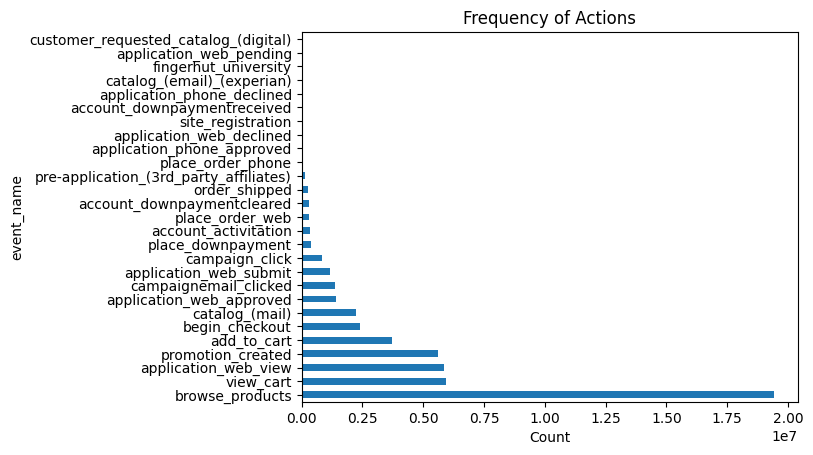

event_name
browse_products                           19422197
view_cart                                  5950083
application_web_view                       5860261
promotion_created                          5587604
add_to_cart                                3694835
begin_checkout                             2406324
catalog_(mail)                             2235274
application_web_approved                   1393357
campaignemail_clicked                      1377725
application_web_submit                     1176459
campaign_click                              849846
place_downpayment                           372910
account_activitation                        357917
place_order_web                             298160
account_downpaymentcleared                  287417
order_shipped                               279363
pre-application_(3rd_party_affiliates)      140792
place_order_phone                            58851
application_phone_approved                   37332
application_web_decl

In [8]:
# common actions

import matplotlib.pyplot as plt

action_counts = df_clean['event_name'].value_counts()

action_counts.plot(kind='barh')
plt.title('Frequency of Actions')
plt.xlabel('Count')
plt.show()

print(action_counts)

In [9]:
# time between individual actions

df_clean = df_clean.sort_values(['customer_id', 'event_timestamp'])

df_clean['time_diff'] = df_clean.groupby('customer_id')['event_timestamp'].diff()

# summary of time between actions (removing the NaT from the first step of every journey)
avg_time_between = df_clean['time_diff'].mean()
median_time_between = df_clean['time_diff'].median()

print(f"Average time between actions: {avg_time_between}")
print(f"Median time between actions: {median_time_between}")

Average time between actions: 3 days 22:52:49.784506994
Median time between actions: 0 days 00:01:28


**Note:** We belive median is a better measure of central tendency here because the mean is sensitive to extreme outliers (the long gaps between visits).

This median time makes sense as users on the platform who are actively using it will have action times around 2 minutes, while those of 3 days are likely due to users leaving the site open as a tab and leaving their computers

#### Additional Exploration

In [10]:
# Conversion Rates

conversion_event = 'order_shipped'

# count unique customers who converted
converted_customers = df_clean[df_clean['event_name'] == conversion_event]['customer_id'].nunique()
total_customers = df_clean['customer_id'].nunique()

conversion_rate = (converted_customers / total_customers) * 100

print(f"Total Customers: {total_customers}")
print(f"Converted Customers: {converted_customers}")
print(f"Conversion Rate: {conversion_rate:.2f}%")

Total Customers: 1391421
Converted Customers: 278243
Conversion Rate: 20.00%


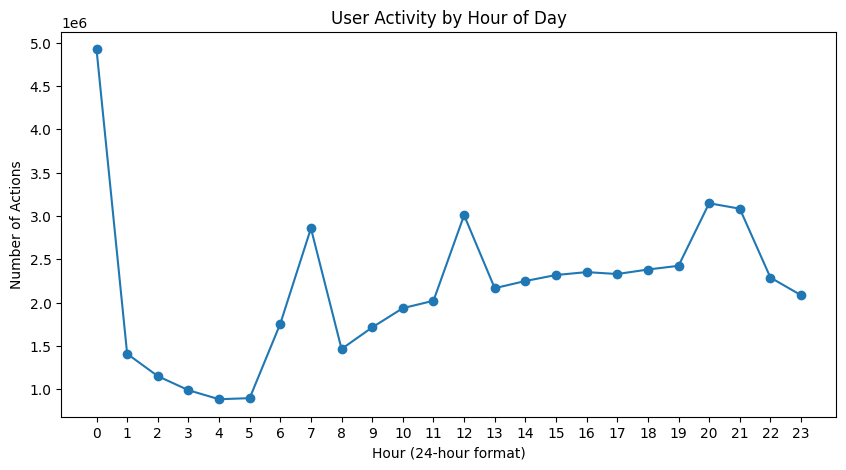

In [11]:
# Hourly Activity (Peak Shopping Times)

import matplotlib.pyplot as plt

df_clean['hour'] = df_clean['event_timestamp'].dt.hour

# count events per hour and sort by the hour of the day
hourly_counts = df_clean['hour'].value_counts().sort_index()

hourly_counts.plot(kind='line', marker='o', figsize=(10, 5))
plt.title('User Activity by Hour of Day')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Actions')
plt.xticks(range(0, 24))
plt.show()

**Observations:** The hourly activity shows a typical peak during evening hours (8 PM - 9 PM), reflecting standard consumer behavior. However, there is an anomalous spike at Hour 0 (midnight). This likely represents automated system batch processing or data logging defaults rather than organic user activity, as we would expect human traffic to be at its lowest during the early morning hours.

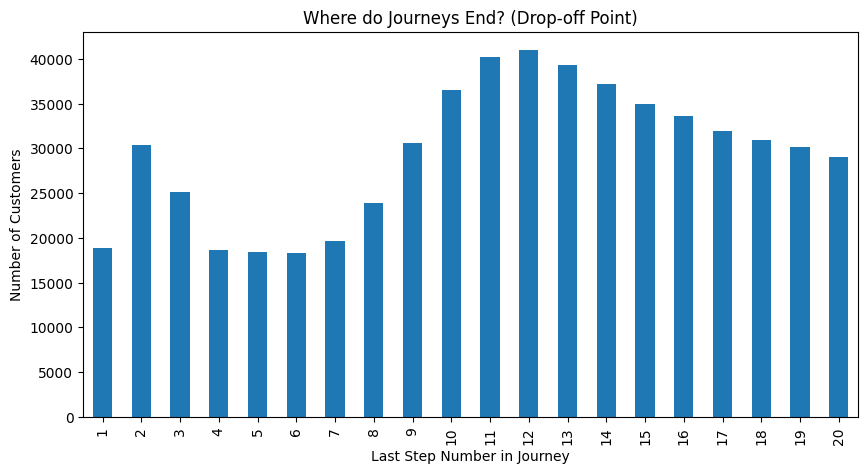

In [12]:
# Drop-off Point ("Surival" of a Journey)

# find the final step reached by every customer
last_steps = df_clean.groupby('customer_id')['journey_steps_until_end'].max()

# count how many journeys ended at step 1, step 2, etc
drop_off_counts = last_steps.value_counts().sort_index().head(20) # Look at first 20 steps

drop_off_counts.plot(kind='bar', figsize=(10, 5))
plt.title('Where do Journeys End? (Drop-off Point)')
plt.xlabel('Last Step Number in Journey')
plt.ylabel('Number of Customers')
plt.show()

**Observations**: It looks like the "average Fingerhut journey" is not just a quick "click and leave." Instead, most users who engage are going through a lengthy process, likely the credit application or browsing a multi-page catalog, before finally exiting. The fact that so many people make it to step 12 before dropping off suggests a high level of engagement or a very long required sequence of actions (like a multi-step form).

## Optional Task 4

In [13]:
import pandas as pd
import numpy as np

# helper columns to make aggregation easier
df_clean['is_appl_submit'] = (df_clean['event_name'] == 'application_web_submit').astype(int)
df_clean['is_shipped'] = (df_clean['event_name'] == 'order_shipped').astype(int)
df_clean['is_add_to_cart'] = (df_clean['event_name'] == 'add_to_cart').astype(int)
df_clean['is_browse'] = (df_clean['event_name'] == 'browse_products').astype(int)

# Flatten the data
df_flat = df_clean.groupby('customer_id').agg(
    total_actions=('journey_steps_until_end', 'max'),
    start_time=('event_timestamp', 'min'),
    end_time=('event_timestamp', 'max'),
    has_applied=('is_appl_submit', 'max'),
    has_shipped=('is_shipped', 'max'),
    max_items_in_cart=('is_add_to_cart', 'sum'), # total times they clicked 'add'
    num_unique_products=('is_browse', 'sum')      # count of browsing events
).reset_index()

# feature engineering

# duration in seconds
df_flat['journey_duration_sec'] = (df_flat['end_time'] - df_flat['start_time']).dt.total_seconds()

# actions per hour
# add a 1-second buffer to avoid division by 0
df_flat['actions_per_hour'] = df_flat['total_actions'] / ((df_flat['journey_duration_sec'] + 1) / 3600)

# start hour
df_flat['start_hour'] = df_flat['start_time'].dt.hour

df_flat = df_flat.drop(columns=['start_time', 'end_time'])

df_flat.head()

,customer_id,total_actions,has_applied,has_shipped,max_items_in_cart,num_unique_products,journey_duration_sec,actions_per_hour,start_hour
0,-2147483541,29,0,0,4,4,20645894.0,0.005057,8
1,-2147474305,32,1,0,0,1,16939969.0,0.006800,22
2,-2147466542,12,0,0,1,1,13597487.0,0.003177,22
3,-2147464266,9,1,0,0,0,87.0,368.181818,9
4,-2147459085,41,1,0,4,19,18863502.0,0.007825,15


**Data Dictionary:**

total_actions: Measures the depth of engagement; higher counts usually indicate higher intent.

journey_duration_sec: Differentiates between "quick sessions" and "long-term shoppers."

actions_per_hour: High velocity can indicate "power users" or bots; low velocity indicates careful browsing.

has_applied: Can be viewed as a "micro-conversion" in the Fingerhut credit-based business model.

has_shipped: Target Variable: Indicates the ultimate success of the journey.

max_items_in_cart: Quantifies the customer's interest in the product catalog.

start_hour: Helps identify "shopping windows" (e.g., late-night vs. lunch-break shopping).

num_unique_products: Measures the breadth of interest across the store's inventory.

# ASSIGNMENT 2

In [17]:
import pandas as pd

# 1. Determine the "Current Date" (latest time in the dataset)
max_date = df_clean['event_timestamp'].max()

# 2. Get the last event for every customer
last_event_per_user = df_clean.sort_values('event_timestamp').groupby('customer_id').tail(1)

# 3. Identify Successful customers (those who ever had an order shipped)
success_ids = set(df_clean[df_clean['event_name'] == 'order_shipped']['customer_id'])

def categorize_journey(row):
    # If they ever ordered, it's a Success
    if row['customer_id'] in success_ids:
        return 'Successful'
    
    # Check inactivity: Difference between their last action and the end of the dataset
    inactivity_period = max_date - row['event_timestamp']
    if inactivity_period >= pd.Timedelta(days=60):
        return 'Incomplete (Lapsed)'
    
    return 'Active/Other'

last_event_per_user['outcome'] = last_event_per_user.apply(categorize_journey, axis=1)

# Merge this label back into your flattened data
df_final = df_flat.merge(last_event_per_user[['customer_id', 'outcome']], on='customer_id')

In [18]:
# Grouping by the new outcome labels
task_1_summary = df_final[df_final['outcome'].isin(['Successful', 'Incomplete (Lapsed)'])].groupby('outcome').agg({
    'total_actions': 'mean',
    'journey_duration_sec': 'mean',
    'num_unique_products': 'mean',
    'has_applied': 'mean'
}).round(2)

print(task_1_summary)

                     total_actions  journey_duration_sec  num_unique_products  \
outcome                                                                         
Incomplete (Lapsed)          31.12           15037521.18                10.63   
Successful                   56.48            5411687.23                23.44   

                     has_applied  
outcome                           
Incomplete (Lapsed)         0.39  
Successful                  0.43  


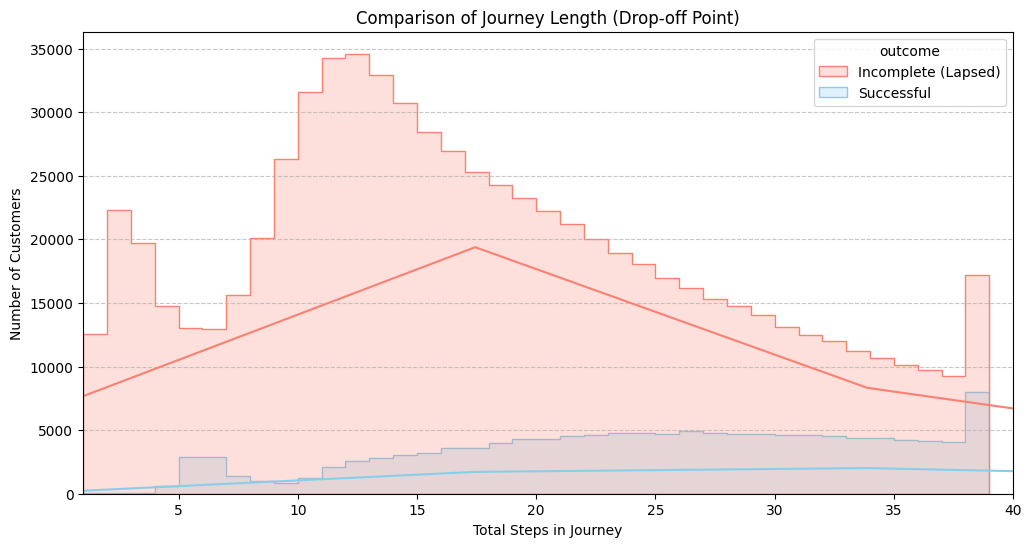

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for only the two main groups we are comparing
df_viz = df_final[df_final['outcome'].isin(['Successful', 'Incomplete (Lapsed)'])]

plt.figure(figsize=(12, 6))
sns.histplot(data=df_viz, x='total_actions', hue='outcome', 
             bins=range(1, 40), kde=True, element="step", palette=['salmon', 'skyblue'])

plt.title('Comparison of Journey Length (Drop-off Point)')
plt.xlabel('Total Steps in Journey')
plt.ylabel('Number of Customers')
plt.xlim(1, 40) # Focus on the first 40 steps where the most movement happens
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/_n/73l507c509q6f8klz4jdkgwr0000gn/T/ipykernel_5832/3768874027.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='outcome', y='num_unique_products', data=df_viz,


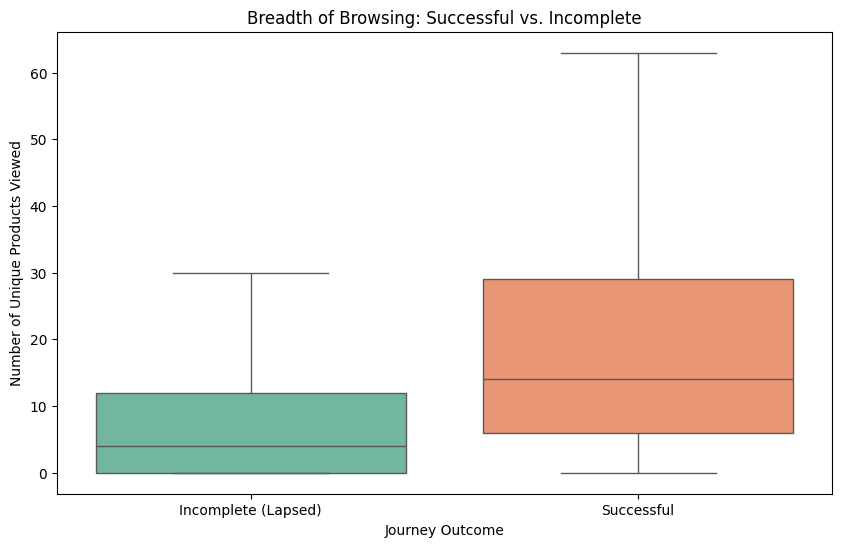

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='outcome', y='num_unique_products', data=df_viz, 
            showfliers=False, palette='Set2')

plt.title('Breadth of Browsing: Successful vs. Incomplete')
plt.ylabel('Number of Unique Products Viewed')
plt.xlabel('Journey Outcome')
plt.show()

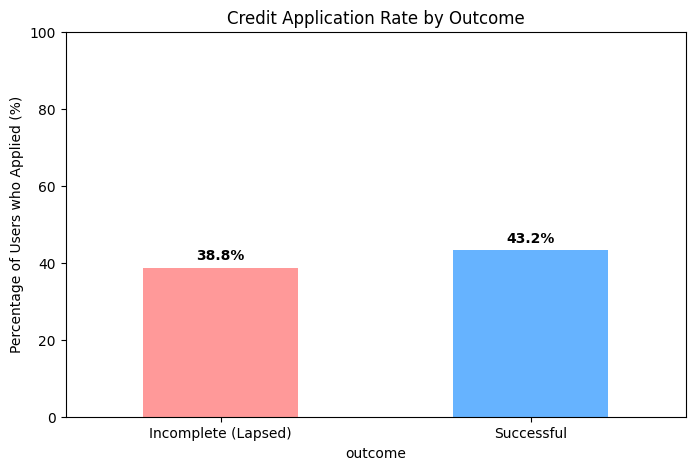

In [21]:
# Calculate rates for the plot
app_rates = df_viz.groupby('outcome')['has_applied'].mean() * 100

plt.figure(figsize=(8, 5))
app_rates.plot(kind='bar', color=['#ff9999','#66b3ff'])

plt.title('Credit Application Rate by Outcome')
plt.ylabel('Percentage of Users who Applied (%)')
plt.xticks(rotation=0)
plt.ylim(0, 100) # Keep scale to 100 to show context

# Add text labels on top of bars
for i, v in enumerate(app_rates):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')

plt.show()

/var/folders/_n/73l507c509q6f8klz4jdkgwr0000gn/T/ipykernel_5832/1887143777.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='outcome', y='duration_days', data=df_viz,


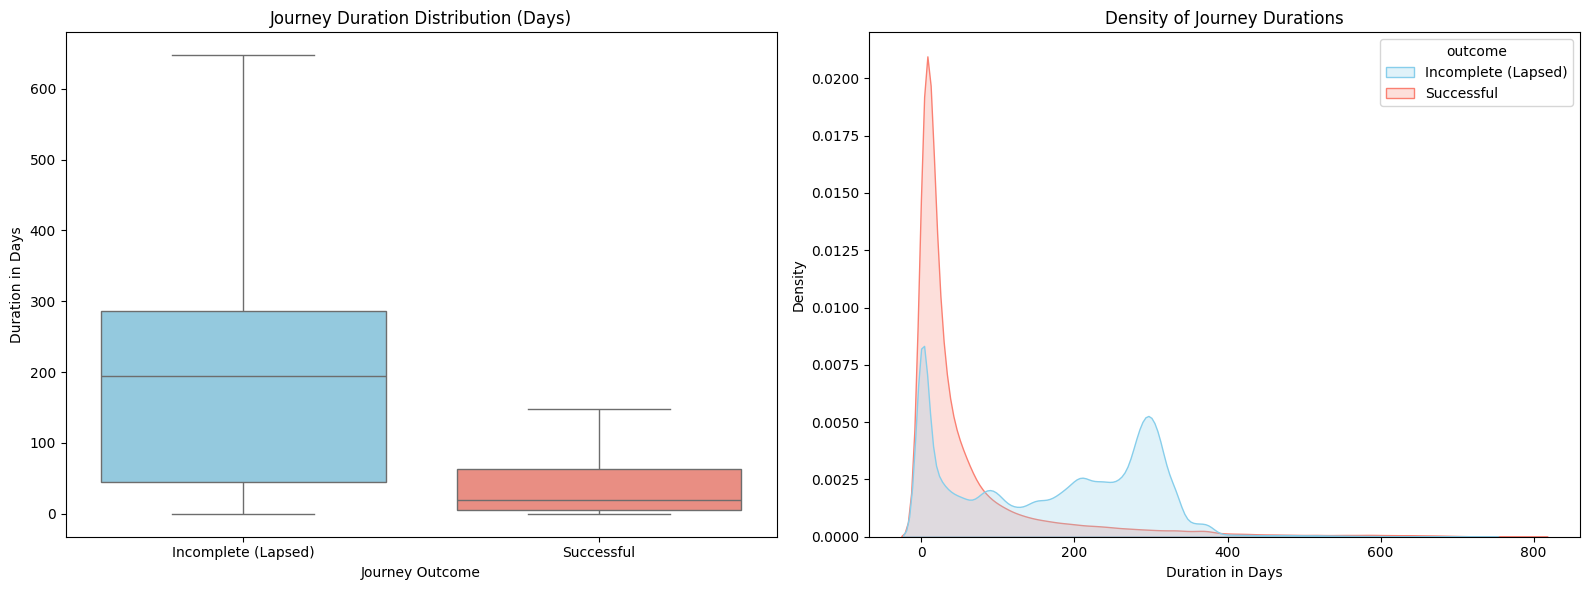

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for the two main comparison groups
df_viz = df_final[df_final['outcome'].isin(['Successful', 'Incomplete (Lapsed)'])].copy()

# Convert seconds to days for better readability on the graph
df_viz['duration_days'] = df_viz['journey_duration_sec'] / (24 * 3600)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Boxplot - Great for comparing medians and spreads
sns.boxplot(ax=axes[0], x='outcome', y='duration_days', data=df_viz, 
            showfliers=False, palette=['skyblue', 'salmon'])
axes[0].set_title('Journey Duration Distribution (Days)')
axes[0].set_ylabel('Duration in Days')
axes[0].set_xlabel('Journey Outcome')

# 2. KDE Plot - Great for seeing the "shape" of the time spent
sns.kdeplot(ax=axes[1], data=df_viz, x='duration_days', hue='outcome', 
            fill=True, common_norm=False, palette=['skyblue', 'salmon'])
axes[1].set_title('Density of Journey Durations')
axes[1].set_xlabel('Duration in Days')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [44]:
# 1. Flatten the Truncated Positive Data (Label 1)
df_train_pos = df_train_pos_raw.groupby('customer_id').agg(
    total_actions=('journey_steps_until_end', 'max'),
    has_applied=('is_appl_submit', 'max'),
    max_items_in_cart=('is_add_to_cart', 'sum'),
    num_unique_products=('is_browse', 'sum')
).reset_index()
df_train_pos['label'] = 1

# 2. Prepare the Incomplete Journeys (Label 0)
# Use your df_final from Task 1 which already identified 'Incomplete (Lapsed)'
df_train_neg = df_final[df_final['outcome'] == 'Incomplete (Lapsed)'][
    ['customer_id', 'total_actions', 'has_applied', 'max_items_in_cart', 'num_unique_products']
].copy()
df_train_neg['label'] = 0

# 3. Combine and Shuffle
df_train = pd.concat([df_train_pos, df_train_neg], ignore_index=True)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [45]:
def add_time_features(df, cut_col='cut_time'):
    # 1. Recency: Seconds between the 'snapshot' and the very last action before that snapshot
    last_action_time = df.groupby('customer_id')['event_timestamp'].transform('max')
    df['recency_seconds'] = (df[cut_col] - last_action_time).dt.total_seconds()

    # 2. Frequency: Total actions in the 24 hours immediately preceding the cut
    day_before_cut = df[cut_col] - pd.Timedelta(days=1)
    df['is_last_24h'] = (df['event_timestamp'] >= day_before_cut).astype(int)
    
    # 3. Time of Day: The hour of the day when the snapshot occurred
    df['snapshot_hour'] = df[cut_col].dt.hour
    
    return df

In [46]:
# Prepare Negative Raw Data
incomplete_ids = df_final[df_final['outcome'] == 'Incomplete (Lapsed)']['customer_id'].unique()
df_train_neg_raw = df_clean[df_clean['customer_id'].isin(incomplete_ids)].copy()

# For Negative journeys, the 'cut_time' is simply their last recorded event
df_train_neg_raw['cut_time'] = df_train_neg_raw.groupby('customer_id')['event_timestamp'].transform('max')

# Apply features to both
df_train_pos_raw = add_time_features(df_train_pos_raw, cut_col='cut_time')
df_train_neg_raw = add_time_features(df_train_neg_raw, cut_col='cut_time')

In [47]:
def flatten_with_bonus(df):
    return df.groupby('customer_id').agg(
        total_actions=('journey_steps_until_end', 'max'),
        has_applied=('is_appl_submit', 'max'),
        max_items_in_cart=('is_add_to_cart', 'sum'),
        num_unique_products=('is_browse', 'sum'),
        # Bonus predictors
        recency=('recency_seconds', 'min'),    
        frequency_24h=('is_last_24h', 'sum'),  
        snapshot_hour=('snapshot_hour', 'first')
    ).reset_index()

# Flatten and Combine
df_train_pos = flatten_with_bonus(df_train_pos_raw)
df_train_pos['label'] = 1

df_train_neg = flatten_with_bonus(df_train_neg_raw)
df_train_neg['label'] = 0

df_train = pd.concat([df_train_pos, df_train_neg], ignore_index=True)



In [48]:
# Fit Random Forest (Task 4)
from sklearn.ensemble import RandomForestClassifier
X = df_train.drop(columns=['label', 'customer_id', 'recency'])
y = df_train['label']

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(X, y)

print(f"OOB Accuracy with Bonus Predictors: {rf.oob_score_:.4f}")

OOB Accuracy with Bonus Predictors: 0.9113


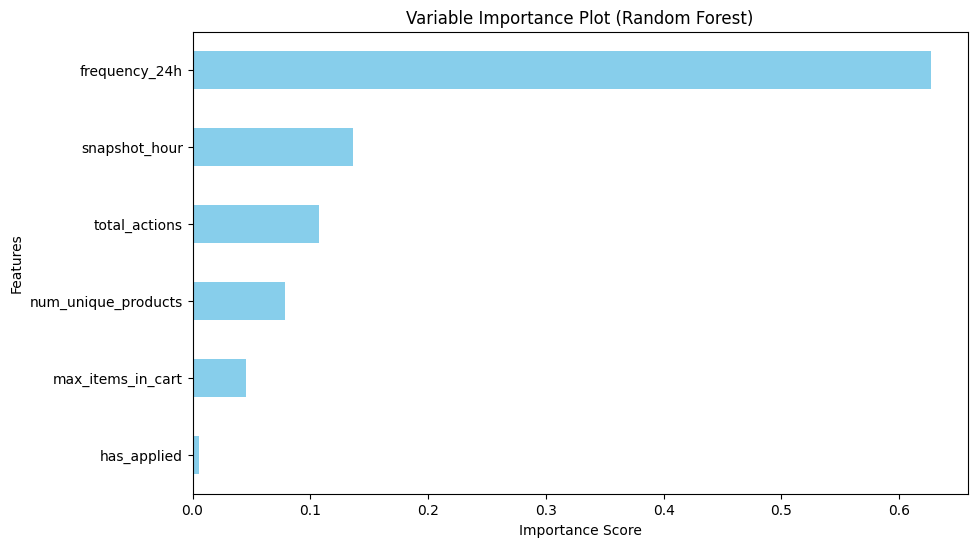

In [50]:
# 4. Generate Variable Importance Plot
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='skyblue')
plt.title('Variable Importance Plot (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()